In [1]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm
from itertools import combinations

warnings.filterwarnings('ignore')

In [2]:
train_feat = pd.read_csv('train_data.csv', index_col=0)
test_feat = pd.read_csv('test_data.csv', index_col=0)
train_flag = pd.read_csv('train_flag.csv', index_col=0)

Добавляем признаки обратные к `amount` и `count` (но не к `std` так как она часто нулевая)

In [3]:
train_feat['amount_inv'] = 1/train_feat['amount']
train_feat['count_inv'] = 1/(train_feat['count'] + 1)
test_feat['amount_inv'] = 1/test_feat['amount']
test_feat['count_inv'] = 1/(test_feat['count'] + 1)

In [4]:
train_feat

,amount,count,std,id_level_1,id_level_2,transaction_id,amount_inv,count_inv
0,376.12,40,0.11,0,0,19752,0.002659,0.024390
1,498.02,53,0.14,0,0,824,0.002008,0.018519
2,272.99,29,0.16,0,0,26418,0.003663,0.033333
3,554.38,59,0.14,0,0,1004,0.001804,0.016667
4,554.86,59,0.17,0,0,15762,0.001802,0.016667
...,...,...,...,...,...,...,...,...
8931645,28.50,3,0.09,54323,116289,518,0.035088,0.250000
8931646,28.79,3,0.42,54323,116289,13122,0.034734,0.250000
8931647,97.03,10,0.38,54323,116289,16014,0.010306,0.090909
8931648,48.30,5,0.25,54323,116289,12002,0.020704,0.166667


In [5]:
test_feat

,amount,count,std,id_level_1,id_level_2,transaction_id,amount_inv,count_inv
0,18.69,2,0.14,4,4,12668,0.053505,0.333333
1,178.67,19,0.20,4,4,6818,0.005597,0.050000
2,18.79,2,0.00,4,4,662,0.053220,0.333333
3,57.13,6,0.12,4,4,15762,0.017504,0.142857
4,47.45,5,0.16,4,4,7494,0.021075,0.166667
...,...,...,...,...,...,...,...,...
2784212,187.72,20,0.15,54319,116277,4302,0.005327,0.047619
2784213,206.90,22,0.20,54319,116277,19194,0.004833,0.043478
2784214,205.85,22,0.11,54319,116277,12002,0.004858,0.043478
2784215,433.87,46,0.18,54319,116277,2364,0.002305,0.021277


Добавляем признаки, полученные путём анализа гистограмм признаков, добавленных на предыдущих шагах (выделение выбросов и “разделение пиков”).  
Эти признаки — бинарные, принимают значения 0 и 1.

In [6]:
train_feat['amount_outlier'] = (train_feat['amount'] > 1500).astype(int)
test_feat['amount_outlier'] = (test_feat['amount'] > 1500).astype(int)

In [7]:
train_feat['std_outlier'] = (train_feat['std'] > 1.5).astype(int)
test_feat['std_outlier'] = (test_feat['std'] > 1.5).astype(int)

In [8]:
train_feat['amount_inv_outlier'] = (train_feat['amount_inv'] > 0.12).astype(int)
test_feat['amount_inv_outlier'] = (test_feat['amount_inv'] > 0.12).astype(int)

In [9]:
train_feat['small_amount'] = (train_feat['amount_inv'] > 0.06).astype(int)
test_feat['small_amount'] = (test_feat['amount_inv'] > 0.06).astype(int)

Добавляем всевозможные попарные произведения признаков, не являющихся бинарными.

In [10]:
def multiply_columns(df, ignore=[], ignore_pairs=[]):
    '''
    Добавляет в датасет столбцы с перемножением фичей.
    Фичи из ignore и пары фичей из ignore_pairs в этом не участвуют.
    '''
    for col1, col2 in tqdm(list(combinations(test_feat.columns, 2))):
        if (col1, col2) not in ignore_pairs and (col2, col1) not in ignore_pairs and \
        col1 not in ignore and col2 not in ignore:
            df[f'{col1}*{col2}'] = df[col1]*df[col2]

In [11]:
multiply_columns(train_feat, ignore=['id_level_1', 'id_level_2', 'transaction_id', 
                                     'small_amount', 'amount_outlier',
                                     'std_outlier', 'amount_inv_outlier'], 
                 ignore_pairs=[('amount', 'amount_inv'), ('count', 'count_inv')])
multiply_columns(test_feat, ignore=['id_level_1', 'id_level_2', 'transaction_id', 
                                     'small_amount', 'amount_outlier',
                                     'std_outlier', 'amount_inv_outlier'], 
                 ignore_pairs=[('amount', 'amount_inv'), ('count', 'count_inv')])

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [12]:
train_feat

,amount,count,std,id_level_1,id_level_2,transaction_id,amount_inv,count_inv,amount_outlier,std_outlier,amount_inv_outlier,small_amount,amount*count,amount*std,amount*count_inv,count*std,count*amount_inv,std*amount_inv,std*count_inv,amount_inv*count_inv
0,376.12,40,0.11,0,0,19752,0.002659,0.024390,0,0,0,0,15044.80,41.3732,9.173659,4.40,0.106349,0.000292,0.002683,0.000065
1,498.02,53,0.14,0,0,824,0.002008,0.018519,0,0,0,0,26395.06,69.7228,9.222593,7.42,0.106421,0.000281,0.002593,0.000037
2,272.99,29,0.16,0,0,26418,0.003663,0.033333,0,0,0,0,7916.71,43.6784,9.099667,4.64,0.106231,0.000586,0.005333,0.000122
3,554.38,59,0.14,0,0,1004,0.001804,0.016667,0,0,0,0,32708.42,77.6132,9.239667,8.26,0.106425,0.000253,0.002333,0.000030
4,554.86,59,0.17,0,0,15762,0.001802,0.016667,0,0,0,0,32736.74,94.3262,9.247667,10.03,0.106333,0.000306,0.002833,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931645,28.50,3,0.09,54323,116289,518,0.035088,0.250000,0,0,0,0,85.50,2.5650,7.125000,0.27,0.105263,0.003158,0.022500,0.008772
8931646,28.79,3,0.42,54323,116289,13122,0.034734,0.250000,0,0,0,0,86.37,12.0918,7.197500,1.26,0.104203,0.014588,0.105000,0.008684
8931647,97.03,10,0.38,54323,116289,16014,0.010306,0.090909,0,0,0,0,970.30,36.8714,8.820909,3.80,0.103061,0.003916,0.034545,0.000937
8931648,48.30,5,0.25,54323,116289,12002,0.020704,0.166667,0,0,0,0,241.50,12.0750,8.050000,1.25,0.103520,0.005176,0.041667,0.003451


In [13]:
test_feat

,amount,count,std,id_level_1,id_level_2,transaction_id,amount_inv,count_inv,amount_outlier,std_outlier,amount_inv_outlier,small_amount,amount*count,amount*std,amount*count_inv,count*std,count*amount_inv,std*amount_inv,std*count_inv,amount_inv*count_inv
0,18.69,2,0.14,4,4,12668,0.053505,0.333333,0,0,0,0,37.38,2.6166,6.230000,0.28,0.107009,0.007491,0.046667,0.017835
1,178.67,19,0.20,4,4,6818,0.005597,0.050000,0,0,0,0,3394.73,35.7340,8.933500,3.80,0.106341,0.001119,0.010000,0.000280
2,18.79,2,0.00,4,4,662,0.053220,0.333333,0,0,0,0,37.58,0.0000,6.263333,0.00,0.106440,0.000000,0.000000,0.017740
3,57.13,6,0.12,4,4,15762,0.017504,0.142857,0,0,0,0,342.78,6.8556,8.161429,0.72,0.105024,0.002100,0.017143,0.002501
4,47.45,5,0.16,4,4,7494,0.021075,0.166667,0,0,0,0,237.25,7.5920,7.908333,0.80,0.105374,0.003372,0.026667,0.003512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784212,187.72,20,0.15,54319,116277,4302,0.005327,0.047619,0,0,0,0,3754.40,28.1580,8.939048,3.00,0.106542,0.000799,0.007143,0.000254
2784213,206.90,22,0.20,54319,116277,19194,0.004833,0.043478,0,0,0,0,4551.80,41.3800,8.995652,4.40,0.106332,0.000967,0.008696,0.000210
2784214,205.85,22,0.11,54319,116277,12002,0.004858,0.043478,0,0,0,0,4528.70,22.6435,8.950000,2.42,0.106874,0.000534,0.004783,0.000211
2784215,433.87,46,0.18,54319,116277,2364,0.002305,0.021277,0,0,0,0,19958.02,78.0966,9.231277,8.28,0.106023,0.000415,0.003830,0.000049


In [14]:
train_flag = train_flag.set_index('id_level_1')
train_flag

,default_in_1y_flag
id_level_1,
0,0
1,0
2,0
3,0
5,0
...,...
54318,0
54320,0
54321,0


Аггрегируем признаки всех предыдущих уровней по аппарату (среднее, стандартное отклонение, коэффициент асимметрии, медиана, максимум, минимум) и также считаем количество вхождений аппарата в датасет.

Для каждого пула транзакций вводим столбецы, соответствующий аггрегированным признакам для его `id_level_2`.

In [15]:
def aggregate_stats(df, target_column, ignore=[]):
    '''
    Вычисляет статистики всех столбцов не из ignore, 
    аггрегированных по целевому столбцу
    '''
    agg = df.drop(columns=ignore).groupby(by=target_column).agg(['mean', 'std', 
                                                                'median', 'min', 
                                                                'max', 'skew']).fillna(-1)
    agg['n_data'] = pd.Series(Counter(df[target_column]))
    return agg

In [16]:
train_feat = pd.merge(train_feat, aggregate_stats(train_feat, 'id_level_2', ignore=['id_level_1', 
                                                                                    'transaction_id']), 
                      on='id_level_2')
test_feat = pd.merge(test_feat, aggregate_stats(test_feat, 'id_level_2', ignore=['id_level_1', 
                                                                                 'transaction_id']), 
                     on='id_level_2')

In [17]:
train_feat

,amount,count,std,id_level_1,id_level_2,transaction_id,amount_inv,count_inv,amount_outlier,std_outlier,...,"(std*count_inv, min)","(std*count_inv, max)","(std*count_inv, skew)","(amount_inv*count_inv, mean)","(amount_inv*count_inv, std)","(amount_inv*count_inv, median)","(amount_inv*count_inv, min)","(amount_inv*count_inv, max)","(amount_inv*count_inv, skew)","(n_data, )"
0,376.12,40,0.11,0,0,19752,0.002659,0.024390,0,0,...,0.001746,0.006552,1.151192,0.000054,0.000027,0.000049,0.000016,0.000131,1.401059,103
1,498.02,53,0.14,0,0,824,0.002008,0.018519,0,0,...,0.001746,0.006552,1.151192,0.000054,0.000027,0.000049,0.000016,0.000131,1.401059,103
2,272.99,29,0.16,0,0,26418,0.003663,0.033333,0,0,...,0.001746,0.006552,1.151192,0.000054,0.000027,0.000049,0.000016,0.000131,1.401059,103
3,554.38,59,0.14,0,0,1004,0.001804,0.016667,0,0,...,0.001746,0.006552,1.151192,0.000054,0.000027,0.000049,0.000016,0.000131,1.401059,103
4,554.86,59,0.17,0,0,15762,0.001802,0.016667,0,0,...,0.001746,0.006552,1.151192,0.000054,0.000027,0.000049,0.000016,0.000131,1.401059,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931645,28.50,3,0.09,54323,116289,518,0.035088,0.250000,0,0,...,0.000000,0.172500,1.287300,0.015111,0.017542,0.008432,0.000651,0.054230,1.476381,53
8931646,28.79,3,0.42,54323,116289,13122,0.034734,0.250000,0,0,...,0.000000,0.172500,1.287300,0.015111,0.017542,0.008432,0.000651,0.054230,1.476381,53
8931647,97.03,10,0.38,54323,116289,16014,0.010306,0.090909,0,0,...,0.000000,0.172500,1.287300,0.015111,0.017542,0.008432,0.000651,0.054230,1.476381,53
8931648,48.30,5,0.25,54323,116289,12002,0.020704,0.166667,0,0,...,0.000000,0.172500,1.287300,0.015111,0.017542,0.008432,0.000651,0.054230,1.476381,53


In [18]:
test_feat

,amount,count,std,id_level_1,id_level_2,transaction_id,amount_inv,count_inv,amount_outlier,std_outlier,...,"(std*count_inv, min)","(std*count_inv, max)","(std*count_inv, skew)","(amount_inv*count_inv, mean)","(amount_inv*count_inv, std)","(amount_inv*count_inv, median)","(amount_inv*count_inv, min)","(amount_inv*count_inv, max)","(amount_inv*count_inv, skew)","(n_data, )"
0,18.69,2,0.14,4,4,12668,0.053505,0.333333,0,0,...,0.0,0.335000,3.955166,0.010656,0.014862,0.005211,0.000280,0.053419,2.134924,168
1,178.67,19,0.20,4,4,6818,0.005597,0.050000,0,0,...,0.0,0.335000,3.955166,0.010656,0.014862,0.005211,0.000280,0.053419,2.134924,168
2,18.79,2,0.00,4,4,662,0.053220,0.333333,0,0,...,0.0,0.335000,3.955166,0.010656,0.014862,0.005211,0.000280,0.053419,2.134924,168
3,57.13,6,0.12,4,4,15762,0.017504,0.142857,0,0,...,0.0,0.335000,3.955166,0.010656,0.014862,0.005211,0.000280,0.053419,2.134924,168
4,47.45,5,0.16,4,4,7494,0.021075,0.166667,0,0,...,0.0,0.335000,3.955166,0.010656,0.014862,0.005211,0.000280,0.053419,2.134924,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2784212,187.72,20,0.15,54319,116277,4302,0.005327,0.047619,0,0,...,0.0,0.087857,6.580156,0.000732,0.004259,0.000211,0.000031,0.053821,11.409847,179
2784213,206.90,22,0.20,54319,116277,19194,0.004833,0.043478,0,0,...,0.0,0.087857,6.580156,0.000732,0.004259,0.000211,0.000031,0.053821,11.409847,179
2784214,205.85,22,0.11,54319,116277,12002,0.004858,0.043478,0,0,...,0.0,0.087857,6.580156,0.000732,0.004259,0.000211,0.000031,0.053821,11.409847,179
2784215,433.87,46,0.18,54319,116277,2364,0.002305,0.021277,0,0,...,0.0,0.087857,6.580156,0.000732,0.004259,0.000211,0.000031,0.053821,11.409847,179


In [21]:
train_tab = aggregate_stats(train_feat, 'id_level_1', ignore=['id_level_2', 'transaction_id']).astype('float64')
test_tab = aggregate_stats(test_feat, 'id_level_1', ignore=['id_level_2', 'transaction_id']).astype('float64')

In [22]:
inf_columns = train_tab.columns[np.isinf(train_tab).any()]
train_tab = train_tab.drop(columns = inf_columns)
test_tab = test_tab.drop(columns = inf_columns)

In [23]:
train_tab

amount                                                  \
                  mean         std   median     min      max      skew   
id_level_1                                                               
0           444.238835   97.995887  434.130  262.95   754.85  0.261542   
1            42.773830   36.301094   29.010    9.22   256.86  2.330363   
2           337.442923  154.179554  312.160   94.17  1245.39  3.365947   
3           591.172711  111.041257  592.770   18.52   899.49 -1.444140   
5            71.208692   41.627436   61.470    9.32   193.98  0.618642   
...                ...         ...      ...     ...      ...       ...   
54318       215.485269   91.967165  227.820    9.46   375.08 -0.535555   
54320        64.468171   42.319750   59.695    9.32   203.81  1.201448   
54321        10.800000    1.490772   10.000    9.88    12.52  1.719434   
54322       180.515341   84.137055  160.715   65.74   789.54  2.791196   
54323        37.170000   25.173175   29.650    9.22   118.16  1.294274   

                count                          ...  \
                 mean        std median   min  ...   
id_level_1                                     ...   
0           47.203883  10.423728   46.0  28.0  ...   
1            4.482270   3.810892    3.0   1.0  ...   
2           35.738462  16.327007   33.0  10.0  ...   
3           60.704819  11.389133   61.0   2.0  ...   
5            7.093458   4.138026    6.0   1.0  ...   
...               ...        ...    ...   ...  ...   
54318       21.279570   9.036599   23.0   1.0  ...   
54320        6.341463   4.169908    6.0   1.0  ...   
54321        1.000000   0.000000    1.0   1.0  ...   
54322       18.960227   8.737022   17.0   7.0  ...   
54323        3.849057   2.612074    3.0   1.0  ...   

           (amount_inv*count_inv, skew)                      (n_data, )  \
                                    min       max      skew        mean   
id_level_1                                                                
0                              1.401059  1.401059  0.000000  103.000000   
1                              1.378801  1.378801  0.000000  141.000000   
2                              4.498554  4.498554  0.000000   65.000000   
3                             -1.000000  1.094637 -9.026726  162.048193   
5                              3.444449  3.444449  0.000000  107.000000   
...                                 ...       ...       ...         ...   
54318                          3.932750  3.932750  0.000000   93.000000   
54320                          2.464206  2.464206  0.000000   82.000000   
54321                         -1.712066 -1.712066  0.000000    3.000000   
54322                          1.556933  1.556933  0.000000  176.000000   
54323                          1.476381  1.476381  0.000000   53.000000   

                                                     n_data  
                  std median    min    max      skew         
id_level_1                                                   
0            0.000000  103.0  103.0  103.0  0.000000  103.0  
1            0.000000  141.0  141.0  141.0  0.000000  141.0  
2            0.000000   65.0   65.0   65.0  0.000000   65.0  
3           17.727844  164.0    2.0  164.0 -9.026726  166.0  
5            0.000000  107.0  107.0  107.0  0.000000  107.0  
...               ...    ...    ...    ...       ...    ...  
54318        0.000000   93.0   93.0   93.0  0.000000   93.0  
54320        0.000000   82.0   82.0   82.0  0.000000   82.0  
54321        0.000000    3.0    3.0    3.0  0.000000    3.0  
54322        0.000000  176.0  176.0  176.0  0.000000  176.0  
54323        0.000000   53.0   53.0   53.0  0.000000   53.0  

[43807 rows x 721 columns]

In [24]:
test_tab

amount                                                 \
                  mean         std   median    min      max      skew   
id_level_1                                                              
4            47.482619   30.617597   38.380   9.36   178.67  1.211719   
10           14.000937    5.511668   12.225   9.62    47.84  3.150048   
20          348.474213  265.568298  280.630   9.36  1911.80  1.274894   
25           27.854588   16.131228   22.450   9.27    72.88  0.926222   
26           47.206762   68.319672   29.700   9.21   810.42  7.605174   
...                ...         ...      ...    ...      ...       ...   
54308       594.113520  231.253897  539.640  18.67  1381.60  0.811840   
54310       360.209718  114.990212  347.950  28.50   778.65  0.428345   
54312        50.917844   36.014586   40.510   9.37   206.94  1.534238   
54313       393.151629  150.262738  416.765  47.17   717.54 -0.477120   
54319       221.988827   94.026702  205.650   9.29   548.46  0.834252   

                count                         ...  \
                 mean        std median  min  ...   
id_level_1                                    ...   
4            4.994048   3.232502    4.0  1.0  ...   
10           1.171875   0.471376    1.0  1.0  ...   
20          35.974468  27.276820   29.0  1.0  ...   
25           2.588235   1.506289    2.0  1.0  ...   
26           4.864754   6.954690    3.0  1.0  ...   
...               ...        ...    ...  ...  ...   
54308       62.603352  24.336457   57.0  2.0  ...   
54310       38.237288  12.224239   37.0  3.0  ...   
54312        5.125749   3.672069    4.0  1.0  ...   
54313       41.595506  15.857928   44.0  5.0  ...   
54319       23.625698   9.984798   22.0  1.0  ...   

           (amount_inv*count_inv, skew)                       (n_data, )  \
                                    min        max      skew        mean   
id_level_1                                                                 
4                              2.134924   2.134924  0.000000  168.000000   
10                            -3.762142   0.844381  0.246590   38.062500   
20                             4.570842  13.187768 -0.083659  176.253901   
25                             0.932675   0.932675  0.000000   85.000000   
26                            -1.000000   2.407980 -0.305967  160.217213   
...                                 ...        ...       ...         ...   
54308                          9.358003   9.358003  0.000000  179.000000   
54310                         10.777591  10.777591  0.000000  177.000000   
54312                          2.178410   2.178410  0.000000  167.000000   
54313                          5.283158   5.283158  0.000000  178.000000   
54319                         11.409847  11.409847  0.000000  179.000000   

                                                     n_data  
                  std median    min    max      skew         
id_level_1                                                   
4            0.000000  168.0  168.0  168.0  0.000000  168.0  
10          14.683404   43.0    3.0   50.0 -0.965016  128.0  
20           0.828772  177.0  175.0  177.0 -0.502635  705.0  
25           0.000000   85.0   85.0   85.0  0.000000   85.0  
26          15.445272  159.0    2.0  169.0 -8.807850  488.0  
...               ...    ...    ...    ...       ...    ...  
54308        0.000000  179.0  179.0  179.0  0.000000  179.0  
54310        0.000000  177.0  177.0  177.0  0.000000  177.0  
54312        0.000000  167.0  167.0  167.0  0.000000  167.0  
54313        0.000000  178.0  178.0  178.0  0.000000  178.0  
54319        0.000000  179.0  179.0  179.0  0.000000  179.0  

[10517 rows x 721 columns]

Обучаем модель

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train_tab, train_flag['default_in_1y_flag'], 
                                                  stratify=train_flag['default_in_1y_flag'], 
                                                  random_state=0)

In [26]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': 0,
          'iterations': 2000,
          'depth': 3,
          'l2_leaf_reg': 4,
          'random_strength': 10
         }
model = CatBoostClassifier(**params)
model.fit(X_train, y_train,
          eval_set=(X_val, y_val),
          use_best_model=True,
          plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5458497	best: 0.5458497 (0)	total: 80.2ms	remaining: 2m 40s
200:	test: 0.7180529	best: 0.7180529 (200)	total: 2.98s	remaining: 26.7s
400:	test: 0.7248093	best: 0.7248305 (395)	total: 5.75s	remaining: 22.9s
600:	test: 0.7262043	best: 0.7264112 (591)	total: 8.33s	remaining: 19.4s
800:	test: 0.7275117	best: 0.7275117 (800)	total: 11s	remaining: 16.5s
1000:	test: 0.7262656	best: 0.7275117 (800)	total: 13.6s	remaining: 13.5s
1200:	test: 0.7225681	best: 0.7275117 (800)	total: 16.2s	remaining: 10.8s
1400:	test: 0.7212679	best: 0.7275117 (800)	total: 18.9s	remaining: 8.09s
1600:	test: 0.7193543	best: 0.7275117 (800)	total: 21.6s	remaining: 5.39s
1800:	test: 0.7183994	best: 0.7275117 (800)	total: 24.2s	remaining: 2.68s
1999:	test: 0.7172410	best: 0.7275117 (800)	total: 26.8s	remaining: 0us

bestTest = 0.7275117385
bestIteration = 800

Shrink model to first 801 iterations.


0.455 val
0.543 train


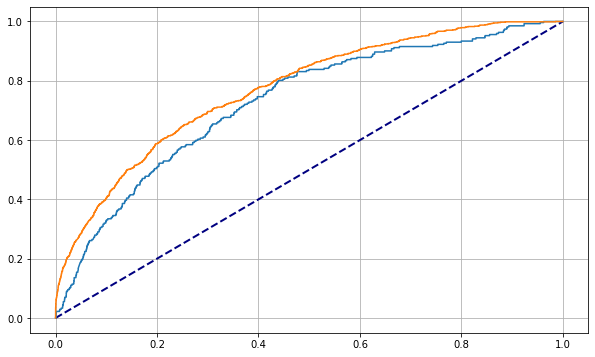

In [27]:
y_val_scores = model.predict_proba(X_val)[:,1]
print(round(2 * roc_auc_score(y_val, y_val_scores)-1, 3), 'val')

y_train_scores = model.predict_proba(X_train)[:,1]
print(round(2 * roc_auc_score(y_train, y_train_scores)-1, 3), 'train')

fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_scores)
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr,tpr)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_scores)
plt.plot(fpr,tpr)
plt.grid(True)
plt.show()

In [28]:
test_tab['score'] = model.predict_proba(test_tab)[:,1]
test_tab

amount                                                 \
                  mean         std   median    min      max      skew   
id_level_1                                                              
4            47.482619   30.617597   38.380   9.36   178.67  1.211719   
10           14.000937    5.511668   12.225   9.62    47.84  3.150048   
20          348.474213  265.568298  280.630   9.36  1911.80  1.274894   
25           27.854588   16.131228   22.450   9.27    72.88  0.926222   
26           47.206762   68.319672   29.700   9.21   810.42  7.605174   
...                ...         ...      ...    ...      ...       ...   
54308       594.113520  231.253897  539.640  18.67  1381.60  0.811840   
54310       360.209718  114.990212  347.950  28.50   778.65  0.428345   
54312        50.917844   36.014586   40.510   9.37   206.94  1.534238   
54313       393.151629  150.262738  416.765  47.17   717.54 -0.477120   
54319       221.988827   94.026702  205.650   9.29   548.46  0.834252   

                count                         ...  \
                 mean        std median  min  ...   
id_level_1                                    ...   
4            4.994048   3.232502    4.0  1.0  ...   
10           1.171875   0.471376    1.0  1.0  ...   
20          35.974468  27.276820   29.0  1.0  ...   
25           2.588235   1.506289    2.0  1.0  ...   
26           4.864754   6.954690    3.0  1.0  ...   
...               ...        ...    ...  ...  ...   
54308       62.603352  24.336457   57.0  2.0  ...   
54310       38.237288  12.224239   37.0  3.0  ...   
54312        5.125749   3.672069    4.0  1.0  ...   
54313       41.595506  15.857928   44.0  5.0  ...   
54319       23.625698   9.984798   22.0  1.0  ...   

           (amount_inv*count_inv, skew)            (n_data, )             \
                                    max      skew        mean        std   
id_level_1                                                                 
4                              2.134924  0.000000  168.000000   0.000000   
10                             0.844381  0.246590   38.062500  14.683404   
20                            13.187768 -0.083659  176.253901   0.828772   
25                             0.932675  0.000000   85.000000   0.000000   
26                             2.407980 -0.305967  160.217213  15.445272   
...                                 ...       ...         ...        ...   
54308                          9.358003  0.000000  179.000000   0.000000   
54310                         10.777591  0.000000  177.000000   0.000000   
54312                          2.178410  0.000000  167.000000   0.000000   
54313                          5.283158  0.000000  178.000000   0.000000   
54319                         11.409847  0.000000  179.000000   0.000000   

                                          n_data     score  
           median    min    max      skew                   
id_level_1                                                  
4           168.0  168.0  168.0  0.000000  168.0  0.041201  
10           43.0    3.0   50.0 -0.965016  128.0  0.017268  
20          177.0  175.0  177.0 -0.502635  705.0  0.005365  
25           85.0   85.0   85.0  0.000000   85.0  0.011885  
26          159.0    2.0  169.0 -8.807850  488.0  0.038537  
...           ...    ...    ...       ...    ...       ...  
54308       179.0  179.0  179.0  0.000000  179.0  0.009736  
54310       177.0  177.0  177.0  0.000000  177.0  0.019138  
54312       167.0  167.0  167.0  0.000000  167.0  0.014820  
54313       178.0  178.0  178.0  0.000000  178.0  0.013858  
54319       179.0  179.0  179.0  0.000000  179.0  0.039846  

[10517 rows x 722 columns]

In [29]:
submit = pd.DataFrame({'id_level_1': test_tab.index.to_numpy(), 'score': test_tab['score'].to_numpy()})
submit

,id_level_1,score
0,4,0.041201
1,10,0.017268
2,20,0.005365
3,25,0.011885
4,26,0.038537
...,...,...
10512,54308,0.009736
10513,54310,0.019138
10514,54312,0.014820
10515,54313,0.013858


In [30]:
submit.to_csv('submission.csv')

Топ-10 признаков

In [33]:
feature_importance = model.get_feature_importance()
feature_ranks = feature_importance.argsort()[::-1]
for j, i in enumerate(feature_ranks[:10]):
    print(j, train_tab.columns[i], feature_importance[i])

0 (('std*count_inv', 'skew'), 'skew') 2.116602143162138
1 (('std', 'median'), 'mean') 1.6591587381732218
2 ('amount*std', 'std') 1.1752076216737628
3 (('count*amount_inv', 'min'), 'min') 1.1716764245028168
4 (('count*amount_inv', 'mean'), 'min') 1.1641205617259436
5 (('std', 'mean'), 'max') 1.1298149531687278
6 ('count*std', 'median') 1.123284151816625
7 (('count*std', 'std'), 'median') 1.0694185539182415
8 ('count*amount_inv', 'skew') 0.9806629500322221
9 (('count*amount_inv', 'max'), 'mean') 0.9758537952734119
